# License detector pipeline visualization

In [21]:
import importlib

import matplotlib

from notebooks.utils import cd_git_root, show, show_contours

matplotlib.rcParams["savefig.pad_inches"] = 0

cd_git_root()

In [22]:
from datasets.load import load_platesmania

datasets = load_platesmania()
ds = datasets.train

paths = ds.paths
to_filter = {
    # 1: "hard",
    # 11: "hard",
    # 12: "hard",
}
paths = [filename for i, filename in enumerate(paths) if i not in to_filter]
path = paths[0]

print("path:", path)

path: datasets/03-platesmania/pl_DW-3YT32_1.jpg


## Image loading

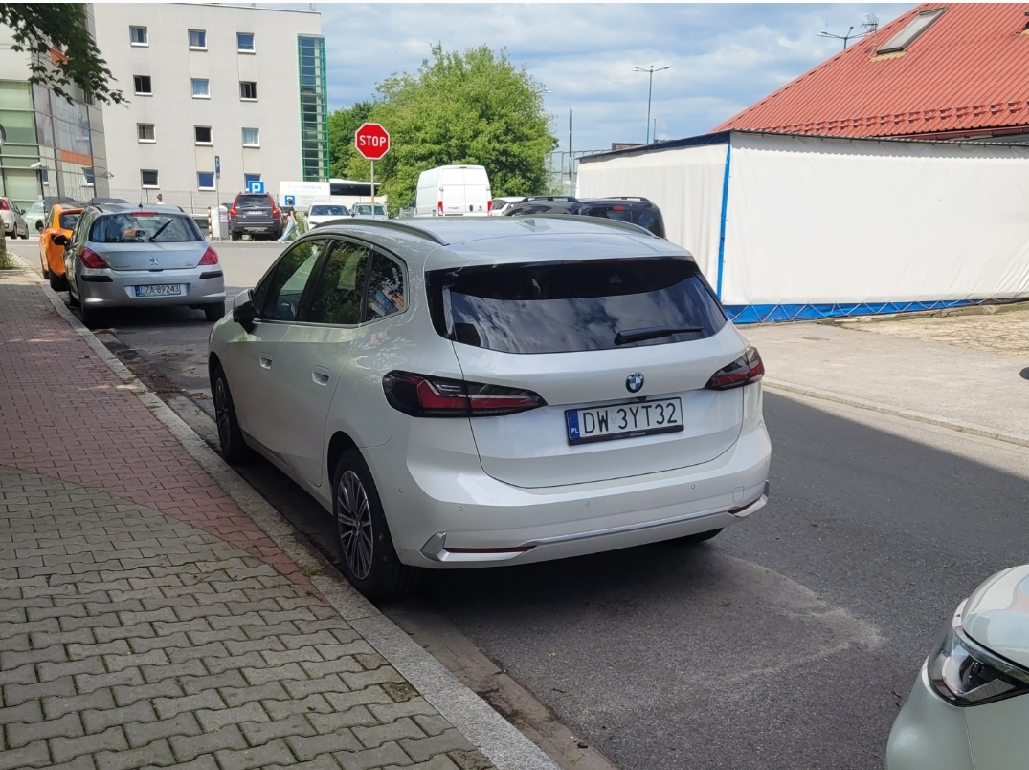

In [23]:
from twm_proj.implementation.image_reader import ImageReader

with open(path, "rb") as file:
    image = ImageReader().read(file)

show(image)

## Initial filtering

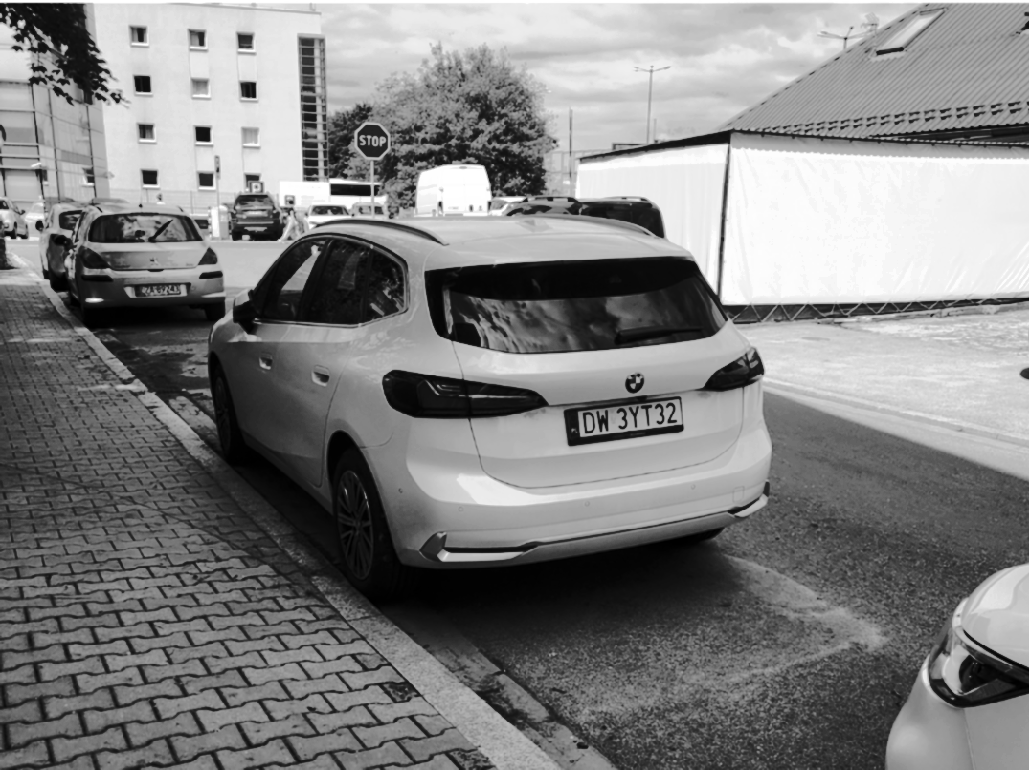

In [24]:
from twm_proj.implementation import initial_filter

importlib.reload(initial_filter)

filtered = initial_filter.InitialFilter().filter(image)
show(filtered)

In [25]:
import cv2
import numpy as np

freq = cv2.dft(filtered.astype(np.float32), flags=cv2.DFT_COMPLEX_OUTPUT)
freq = 20 * np.log(cv2.magnitude(freq[:, :, 0], freq[:, :, 1]))
height, width = freq.shape[:2]
height, width = height // 2, width // 2
freq = freq[: height, : width]
freq = cv2.normalize(freq, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
xs, ys = np.meshgrid(np.arange(height) / height, np.arange(width) / width)
points = np.vstack([ys.ravel(), xs.ravel()]).T.reshape(width, height, 2).transpose((1, 0, 2))
dists = np.sqrt(np.square(points).sum(axis=2))
# show((dists / dists.max() * 255).astype(np.uint8))
# show(freq)
avg_freq = np.mean([dist * freq for dist, freq in zip(dists.flat, freq.flat)])
print("detail level:", avg_freq)


detail level: 87.7285722495026


## Edge filter

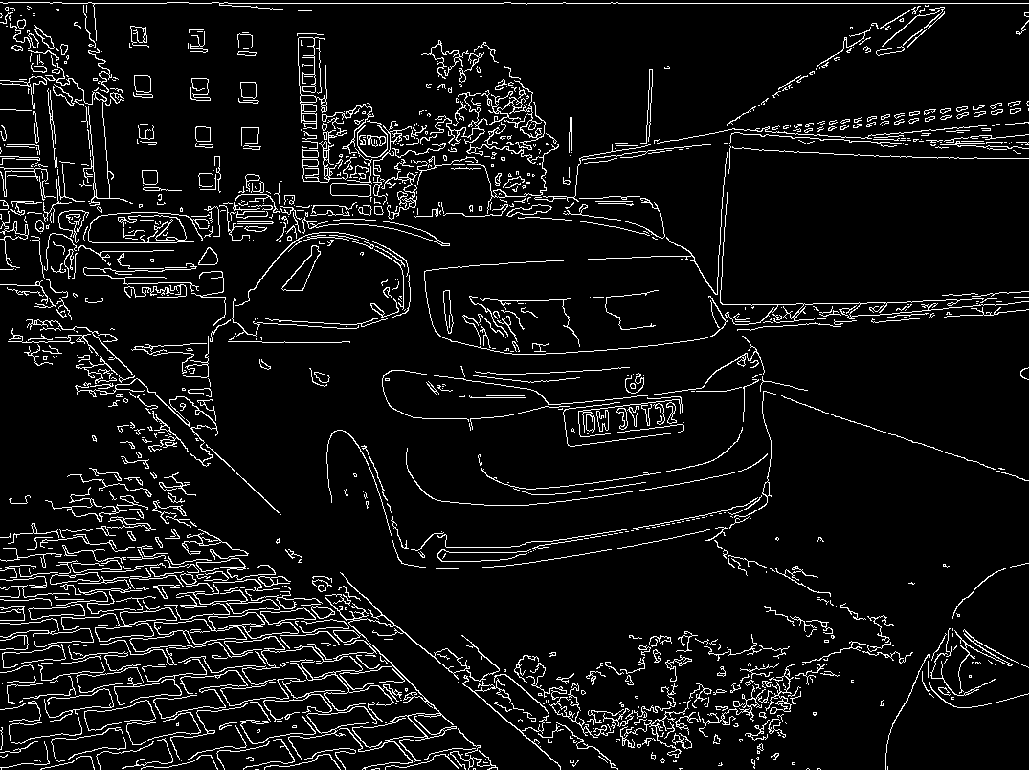

In [26]:
from twm_proj.implementation import edge_filter
importlib.reload(edge_filter)

edges = edge_filter.EdgeFilter().filter(filtered)
show(edges)

## Contour detector

contours count: 97


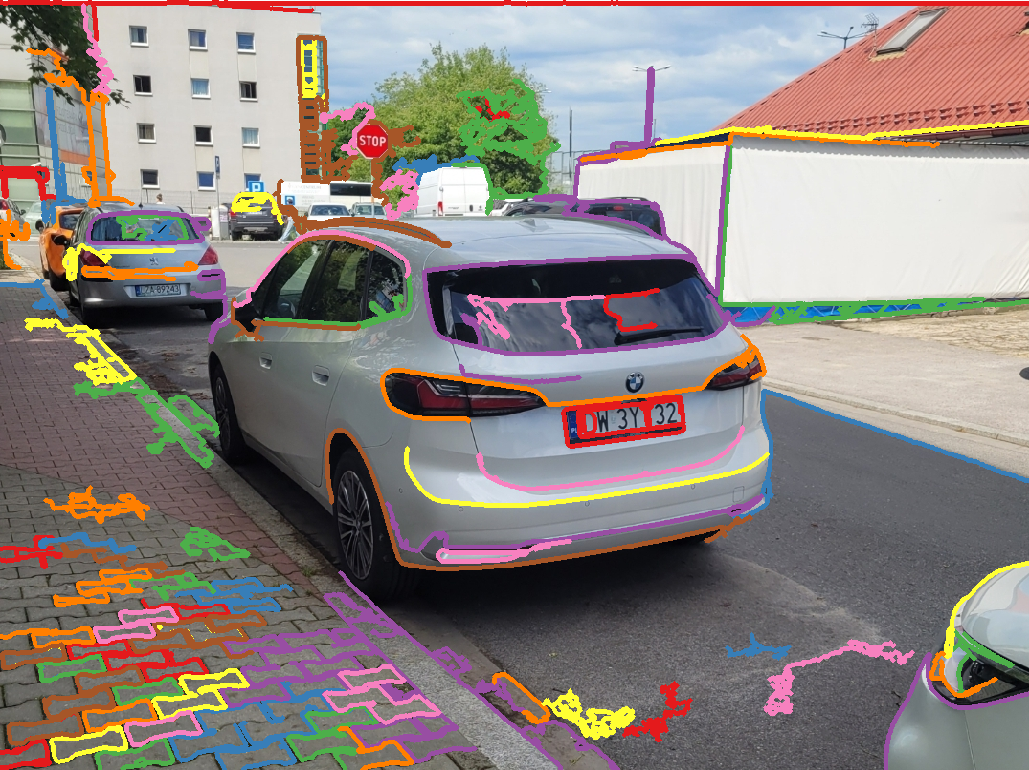

In [27]:
from twm_proj.implementation import contour_detector

from notebooks.utils import filter_by_color

importlib.reload(contour_detector)

contours = [*contour_detector.ContourDetector().detect(edges)]
print("contours count:", len(contours))
filtered_contours = filter_by_color(contours)
show_contours(image, filtered_contours)

## Rectangle detection

rects count: 34
example rect:
 [[ 54 777]
 [ 58 800]
 [131 787]
 [127 769]]


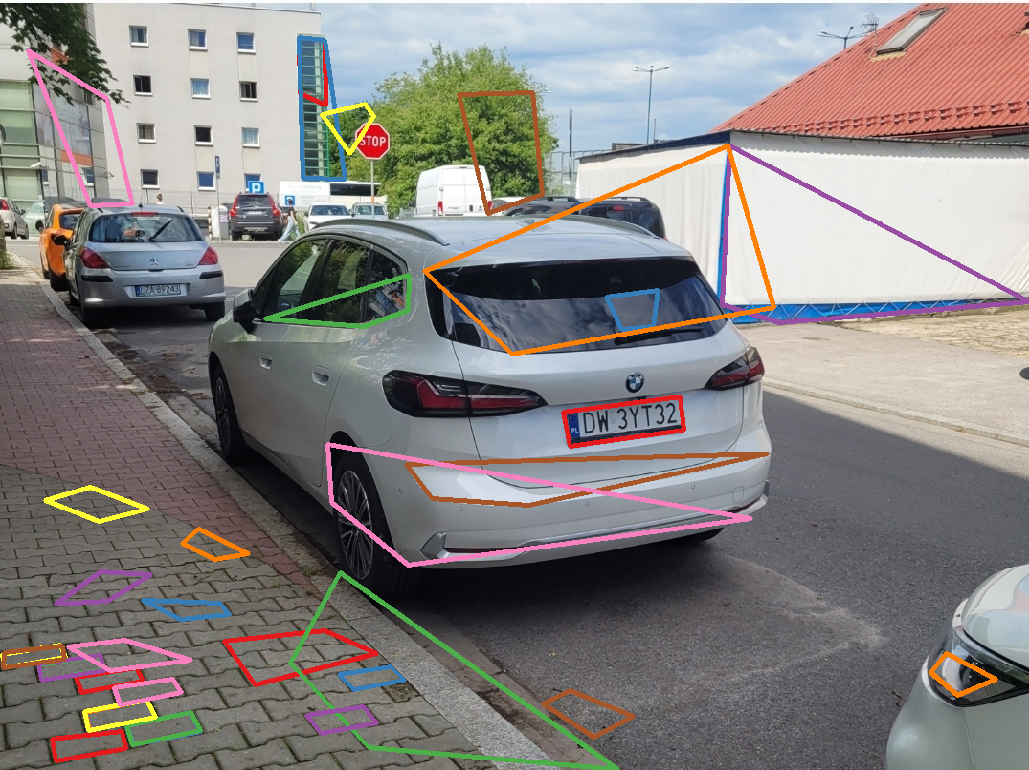

In [28]:
from twm_proj.implementation import rect_detector

importlib.reload(rect_detector)

rects = [rect_detector.RectDetector().detect(contour) for contour in filtered_contours]
rects = [rect for rect in rects if rect is not None]
print("rects count:", len(rects))
print("example rect:\n", rects[0] if rects else None)
show_contours(image, rects)

## Rectangle transforming

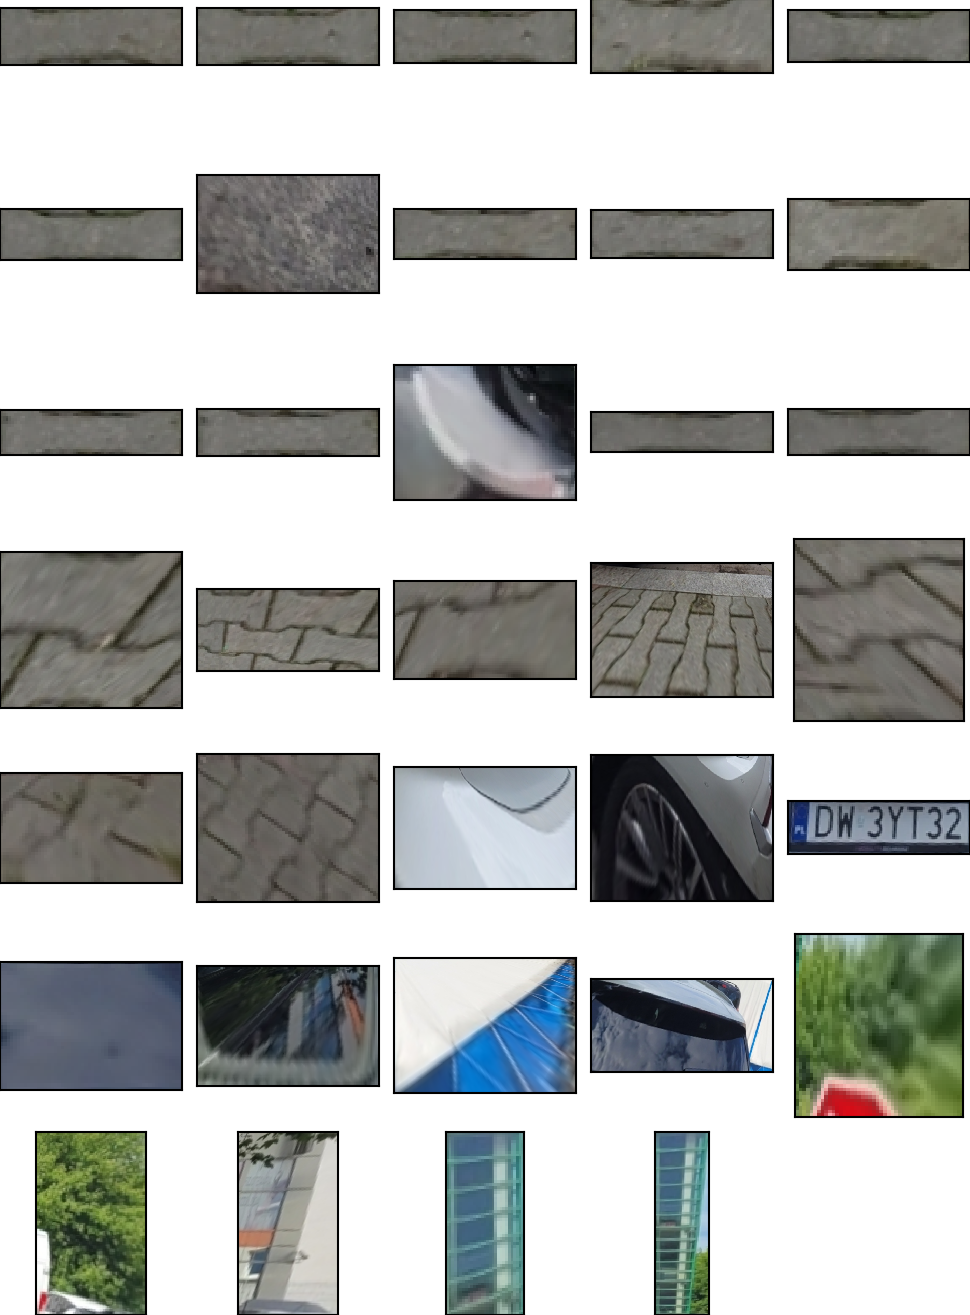

In [29]:
from twm_proj.implementation.rect_transformer import RectTransformer
from notebooks.utils import show_collage

rect_images = [RectTransformer().transform(image, rect) for rect in rects]
show_collage(rect_images, height=2)

## Rectangle classification

In [30]:
from twm_proj.implementation.rect_classifier import RectClassifier
from twm_proj.interface.rect_classifier import RectangleType

rect_classes = [RectClassifier().classify_with_differences(img) for img in rect_images]
display([(rect_class.name, differences) for rect_class, differences in rect_classes])

plates = [
    rect
    for rect, cls in zip(rect_images, rect_classes)
    if cls != RectangleType.NOT_PLATE
]

[('MINI_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.2946488294314381,
   <RectangleType.TWO_ROW_PLATE: 2>: 1.257448325017819,
   <RectangleType.MINI_PLATE: 3>: 0.1643892339544514}),
 ('MINI_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.2924825174825175,
   <RectangleType.TWO_ROW_PLATE: 2>: 1.264381520119225,
   <RectangleType.MINI_PLATE: 3>: 0.16796536796536793}),
 ('NOT_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.24835164835164839,
   <RectangleType.TWO_ROW_PLATE: 2>: 1.4056206088992973,
   <RectangleType.MINI_PLATE: 3>: 0.24081632653061222}),
 ('MINI_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.4610576923076923,
   <RectangleType.TWO_ROW_PLATE: 2>: 0.7248633879781422,
   <RectangleType.MINI_PLATE: 3>: 0.11031746031746024}),
 ('NOT_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.2326923076923077,
   <RectangleType.TWO_ROW_PLATE: 2>: 1.455737704918033,
   <RectangleType.MINI_PLATE: 3>: 0.2666666666666667}),
 ('NOT_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.22173076923076926

## Pre-OCR processing

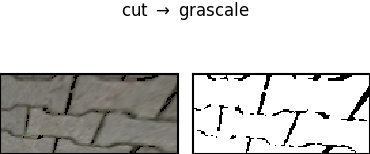

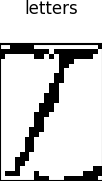

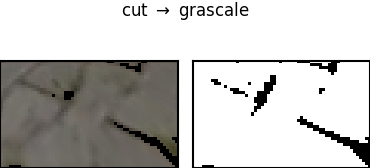

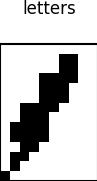

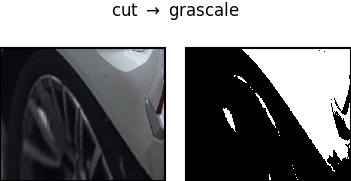

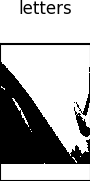

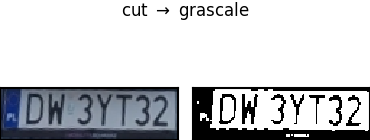

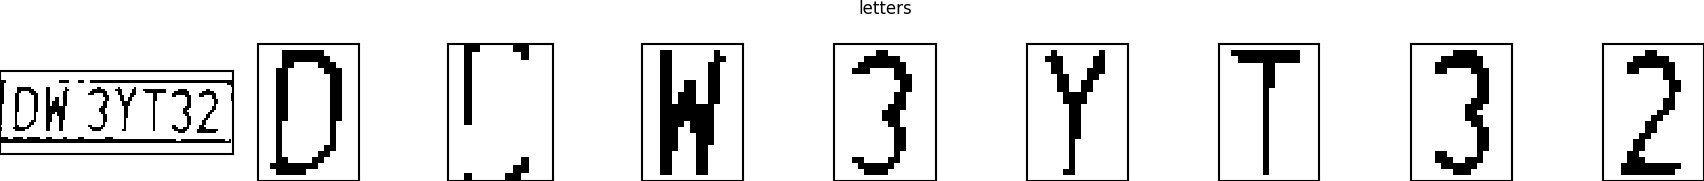

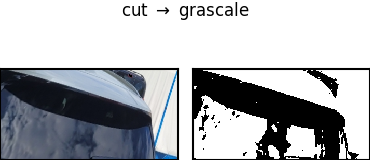

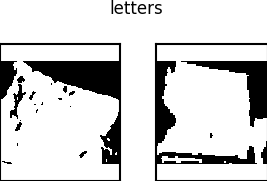

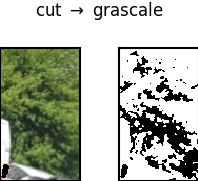

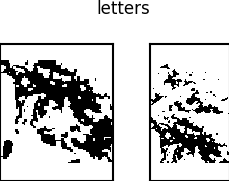

In [31]:
from twm_proj.implementation import pre_ocr

importlib.reload(pre_ocr)

plate_letters = []

for plate in plates:
    plate_cut = pre_ocr.PreOcr().cut(plate)
    plate_gray = pre_ocr.PreOcr().to_grayscale(plate_cut)

    letters = [*pre_ocr.PreOcr().get_letters(plate_gray)]
    if len(letters) > 0:
        grid1 = show_collage([plate, plate_gray], col_wrap=2, height=2)
        grid1.fig.set_tight_layout(True)
        grid1.fig.suptitle("cut $\\rightarrow$ grascale")
        grid2 = show_collage(letters, col_wrap=len(letters), height=2)
        grid2.fig.set_tight_layout(True)
        grid2.fig.suptitle("letters")

        plate_letters.append(letters)

## OCR

In [32]:
from twm_proj.implementation.ocr import Ocr


for letters in plate_letters:
    scanned_text = Ocr().scan_text(letters)
    print(scanned_text if scanned_text else None)

A
A
K
ADAW3YT32
TA
AA
